In [1]:
from IPython.display import display
from dataclasses import dataclass
import datetime
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.options.display.max_columns = None

from elarb.policy import (
    optimal_policy, PolicyInput, PolicyOutput
)
from elarb.models import (
    SolarPanel,
    Battery,
    GridConnection,
    Inverter,
)
from elarb import datasets

In [2]:
n_panels = widgets.IntSlider(value=100, min=0, max=200, description='Solar panels:', continuous_update=True)
n_inverters = widgets.IntSlider(value=3, min=0, max=10, description='Inverters:', continuous_update=True)
n_batteries = widgets.IntSlider(value=9, min=0, max=10, description='Batteries:', continuous_update=True)
stikledning_amp = widgets.IntSlider(value=63.0, min=0, max=100, description='Ampere:', continuous_update=True)
stikledning_volt = widgets.IntSlider(value=400, min=0, max=500, description='Volt:', continuous_update=True)

## Load data

In [3]:
df_nordpool = pd.read_csv('../data/nordpool_21_22.csv', parse_dates=['HourUTC', 'HourDK', 'dt'])
df_nordpool.head(3)

,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR,dt,h
0,2020-12-31 23:00:00,2021-01-01 00:00:00,DK2,378.519989,50.869999,2021-01-01,0
1,2021-01-01 00:00:00,2021-01-01 01:00:00,DK2,358.579987,48.189999,2021-01-01,1
2,2021-01-01 01:00:00,2021-01-01 02:00:00,DK2,332.459991,44.680000,2021-01-01,2


In [27]:
year = 2021
df = df_nordpool[(df_nordpool.HourDK.dt.year == year)]
date = df.sample(n=1).iloc[0, :]

In [35]:
df_pv = pd.read_csv('../data/pvwatts.csv')
df_pv.head(3)

,Month,Day,Hour,Beam Irradiance (W/m^2),Diffuse Irradiance (W/m^2),Ambient Temperature (C),Wind Speed (m/s),Plane of Array Irradiance (W/m^2),Cell Temperature (C),DC Array Output (W),AC System Output (W)
0,1,1,0,0,0,7.0,11.3,0.0,7,0.0,0.0
1,1,1,1,0,0,7.1,12.7,0.0,7,0.0,0.0
2,1,1,2,0,0,7.2,14.0,0.0,7,0.0,0.0


## Helper functions

In [40]:
def filter_pv(df_pv, df_nordpool):
    df_pv = df_pv.sort_values(by=['Month', 'Day', 'Hour'])
    df_nordpool = df_nordpool.sort_values(by='HourDK')
    ts0 = df_nordpool.HourDK.min()
    ts1 = df_nordpool.HourDK.max()
    idx0 = df_pv[(df_pv.Month == ts0.month) & (df_pv.Day == ts0.day) & (df_pv.Hour == ts0.hour)].index[0]
    idx1 = df_pv[(df_pv.Month == ts1.month) & (df_pv.Day == ts1.day) & (df_pv.Hour == ts1.hour)].index[0]+1
    df_pv_win = df_pv[idx0:idx1].reset_index().copy()
    return df_pv_win

In [41]:
@dataclass
class MonthlyData:
    year: int
    month: int
    nordpool: pd.DataFrame
    pv: pd.DataFrame

def iterate_months(df_nordpool, df_pv):
    cols = [df_nordpool.HourDK.dt.year, df_nordpool.HourDK.dt.month]
    for (year, month), _nordpool in df_nordpool.groupby(cols):
        _pv = filter_pv(df_pv, _nordpool)
        yield MonthlyData(
            year=year,
            month=month,
            nordpool=_nordpool,
            pv=_pv
        )

In [20]:
# example
for md in iterate_months(df_nordpool, df_pv):
    print(md.year, md.month, len(md.nordpool), len(md.pv))
    break

2021 1 744 744


## Configure and optimise

In [41]:
BIGNUM = 100

In [42]:
display(n_panels)
display(n_inverters)
display(n_batteries)
display(stikledning_amp)
display(stikledning_volt)

IntSlider(value=100, description='Solar panels:', max=200)

IntSlider(value=3, description='Inverters:', max=10)

IntSlider(value=9, description='Batteries:', max=10)

IntSlider(value=63, description='Ampere:')

IntSlider(value=400, description='Volt:', max=500)

In [29]:
# solar panels: 470Wp JinKO TigerNeo N-Type 60HL4 BF, 1.57 kWh / time, costs 1565 DKK
panel = SolarPanel(m2=0.75, depreciation_per_hour=0.0059)
# DK grid
grid = GridConnection(throughput_kWh=stikledning_amp.value * stikledning_volt.value / 1000)
# Deye SUN-12K-SG04LP3-EU
inverter = Inverter(depreciation_per_hour=0.0, throughput_kWh=15.6, conversion_loss_pct=0.03,)
# battery: Powerwall LBATTS Powerwall, 8.8 kwh
battery = Battery(depreciation_per_kWh=0.398, throughput_kWh=3.3, capacity_kWh=8.8, conversion_loss_pct=0.03,)
print(panel)
print(grid)
print(inverter)
print(battery)

SolarPanel(m2=0.75, depreciation_per_hour=0.0059)
GridConnection(throughput_kWh=25.2)
Inverter(throughput_kWh=15.6, depreciation_per_hour=0.0, conversion_loss_pct=0.03)
Battery(capacity_kWh=8.8, throughput_kWh=3.3, conversion_loss_pct=0.03, depreciation_per_kWh=0.398)


In [43]:
@dataclass
class Sample:
    ts: np.ndarray
    spot_dkk: np.ndarray
    pv_kWh: np.ndarray
    result: PolicyOutput
        
@dataclass
class Config:
    panel: SolarPanel
    battery: Battery
    inverter: Inverter
    grid: GridConnection
    n_panels: int
    n_batteries: int
    n_inverters: int

def solve(md: MonthlyData, conf: Config):
    print('start solve', md.year, md.month, len(md.nordpool), len(md.pv))
    BIGNUM = 1000

    n_hours = len(md.nordpool)
    spot_price=md.nordpool.SpotPriceDKK.values/1000
    pv_kWh = md.pv['AC System Output (W)'].values / 1000

    policy_input = PolicyInput(
        pv_kWh=pv_kWh,
        spot_price=spot_price,
        spot_demand_kWh=np.zeros(n_hours) + BIGNUM,
        spot_supply_kWh=np.zeros(n_hours) + BIGNUM,
        panel=conf.panel,
        battery=conf.battery,
        inverter=conf.inverter,
        grid=conf.grid,
        n_panels=conf.n_panels,
        n_batteries=conf.n_batteries,
        n_inverters=conf.n_inverters,
        initial_soc=0.0
    )
    res = optimal_policy(policy_input)
    return Sample(
        ts=md.nordpool.HourDK, 
        spot_dkk=md.nordpool.SpotPriceDKK,
        pv_kWh=pv_kWh,
        result=res
    )


In [108]:
conf = Config(
    panel=panel,
    battery=battery,
    inverter=inverter,
    grid=grid,
    n_panels=n_panels.value,
    n_batteries=n_batteries.value,
    n_inverters=n_inverters.value
)

samples = [solve(md, conf) for md in iterate_months(df_nordpool, df_pv) if len(md.nordpool) == len(md.pv)]

start solve 2021 1 744 744
start solve 2021 2 672 672
start solve 2021 4 720 720
start solve 2021 5 744 744
start solve 2021 6 720 720
start solve 2021 7 744 744
start solve 2021 8 744 744
start solve 2021 9 720 720
start solve 2021 11 720 720
start solve 2021 12 744 744
start solve 2022 1 744 744
start solve 2022 2 672 672
start solve 2022 4 720 720
start solve 2022 5 744 744
start solve 2022 6 720 720
start solve 2022 7 744 744
start solve 2022 8 744 744
start solve 2022 9 720 720
start solve 2022 10 408 408


In [109]:
df_samp = pd.DataFrame({
    'year': [o.ts.min().year for o in samples],
    'month': [o.ts.min().month for o in samples],
    'start_ts': [o.ts.min() for o in samples],
    'end_ts': [o.ts.max() for o in samples],
    'dkk': [o.result.value for o in samples],
    'dkk_x1': [o.result.x1_contrib for o in samples],
    'dkk_x2': [o.result.x2_contrib for o in samples],
    'dkk_x3': [o.result.x3_contrib for o in samples],
    'yield_x4': [o.result.x4_contrib for o in samples],
    'kWh': [o.result.x1.sum()+o.result.x3.sum() for o in samples],
    'kWh_x1': [o.result.x1.sum() for o in samples],
    'kWh_x2': [o.result.x2.sum() for o in samples],
    'kWh_x3': [o.result.x3.sum() for o in samples],
    'kWh_x4': [o.result.x4.sum() for o in samples],
    'depr_panel': [o.result.panel_depreciation for o in samples],
    'depr_battery': [o.result.battery_depreciation for o in samples],
    'n_panel': [n_panels.value for _ in range(len(samples))],
    'n_battery': [n_batteries.value for _ in range(len(samples))],
    'grid_amp': [stikledning_amp.value for _ in range(len(samples))],
    'grid_volt': [stikledning_volt.value for _ in range(len(samples))],
    'spot_min': [o.spot_dkk.min() for o in samples],
    'spot_max': [o.spot_dkk.max() for o in samples],
    'spot_mean': [o.spot_dkk.mean() for o in samples],
    'spot_std': [o.spot_dkk.std() for o in samples],
    'pv_kWh_min': [o.pv_kWh.min() for o in samples],
    'pv_kWh_max': [o.pv_kWh.max() for o in samples],
    'pv_kWh_mean': [o.pv_kWh.mean() for o in samples],
    'pv_kWh_std': [o.pv_kWh.std() for o in samples],    
}).round(2)
df_samp.to_csv('../data/simulation_monthly_21_22.csv', index=False)
df_samp.head(3)

,year,month,start_ts,end_ts,dkk,dkk_x1,dkk_x2,dkk_x3,yield_x4,kWh,kWh_x1,kWh_x2,kWh_x3,kWh_x4,depr_panel,depr_battery,n_panel,n_battery,grid_amp,grid_volt,spot_min,spot_max,spot_mean,spot_std,pv_kWh_min,pv_kWh_max,pv_kWh_mean,pv_kWh_std
0,2021,1,2021-01-01,2021-01-31 23:00:00,351.75,731.45,0.0,205.03,-30.84,2079.45,1790.65,128.39,288.79,169.34,438.96,114.94,100,9,63,400,82.44,818.35,378.34,124.86,0.0,0.52,0.03,0.09
1,2021,2,2021-02-01,2021-02-28 23:00:00,1218.32,1238.70,0.0,875.04,-120.85,3628.01,2678.04,613.74,949.96,365.60,396.48,378.09,100,9,63,400,167.17,1859.38,405.66,213.48,0.0,0.72,0.07,0.15
2,2021,4,2021-04-01,2021-04-30 23:00:00,1955.40,2167.69,0.0,711.30,6.38,7055.22,5785.95,1129.66,1269.27,178.86,424.80,505.17,100,9,63,400,-86.21,929.65,355.94,159.46,0.0,0.83,0.15,0.22


In [110]:
yearly = df_samp.groupby('year').agg(
    total_dkk=('dkk', np.sum),
    n_months=('dkk', len)
)
yearly['norm'] = (12/yearly.n_months)
yearly['total_dkk_extrapolated'] = yearly.total_dkk * yearly.norm
yearly

,total_dkk,n_months,norm,total_dkk_extrapolated
year,,,,
2021,33485.15,10,1.200000,40182.18
2022,103825.32,9,1.333333,138433.76


## Visualisations

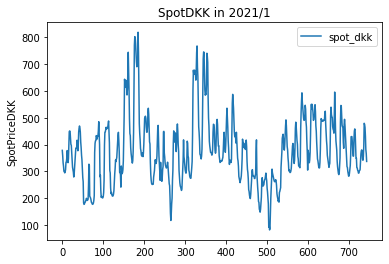

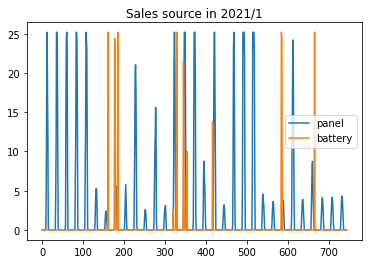

In [118]:
md = samples[0]
sns.lineplot(data=md.spot_dkk, label='spot_dkk')
plt.legend()
plt.title(f'SpotDKK in {md.ts.min().year}/{md.ts.min().month}')
plt.show()
sns.lineplot(data=md.result.x1, label='panel')
sns.lineplot(data=md.result.x3, label='battery')
plt.legend()
plt.title(f'Sales source in {md.ts.min().year}/{md.ts.min().month}')
plt.show()

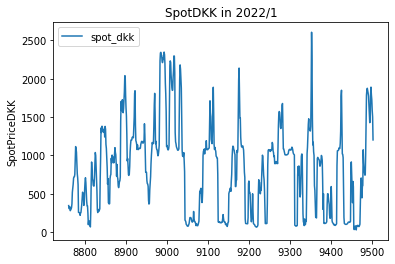

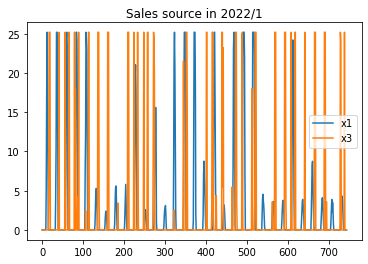

In [119]:
md = samples[10]
sns.lineplot(data=md.spot_dkk, label='spot_dkk')
plt.legend()
plt.title(f'SpotDKK in {md.ts.min().year}/{md.ts.min().month}')
plt.show()
sns.lineplot(data=md.result.x1, label='x1')
sns.lineplot(data=md.result.x3, label='x3')
plt.legend()
plt.title(f'Sales source in {md.ts.min().year}/{md.ts.min().month}')
plt.show()

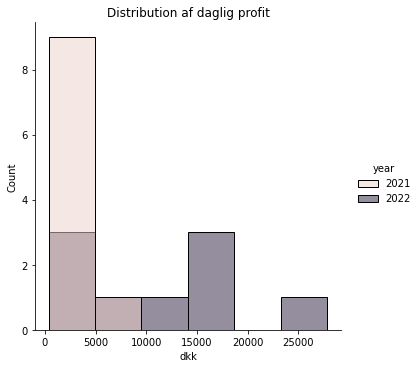

In [90]:
sns.displot(data=df_samp, x='dkk', hue='year')
plt.title('Distribution af daglig profit')
plt.show()

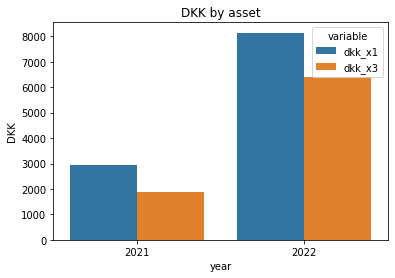

In [91]:
cols = ['year', 'dkk_x1', 'dkk_x3']
df_plot = df_samp.groupby('year').mean().reset_index().loc[:, cols].melt(id_vars='year')
sns.barplot(data=df_plot, x='year', y='value', hue='variable')
plt.ylabel('DKK')
plt.title('DKK by asset')
plt.show()
#df_plot

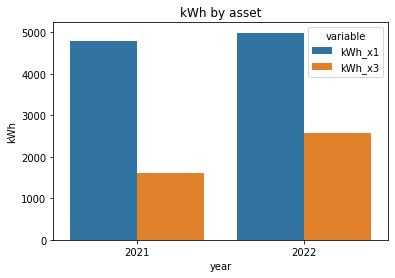

In [92]:
cols = ['year', 'kWh_x1', 'kWh_x3']
df_plot = df_samp.groupby('year').mean().reset_index().loc[:, cols].melt(id_vars='year')
sns.barplot(data=df_plot, x='year', y='value', hue='variable')
plt.ylabel('kWh')
plt.title('kWh by asset')
plt.show()
#df_plot

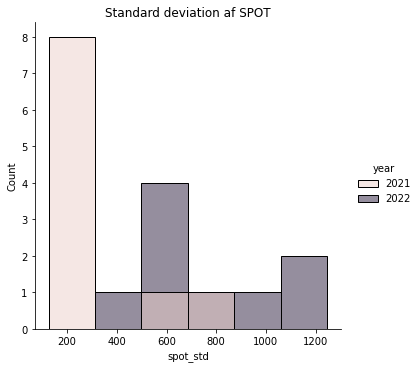

In [93]:
sns.displot(data=df_samp, x='spot_std', hue='year')
plt.title('Standard deviation af SPOT')
plt.show()

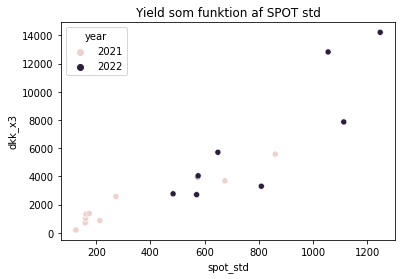

In [95]:
sns.scatterplot(data=df_samp, x='spot_std', y='dkk_x3', hue='year')
plt.title('Yield som funktion af SPOT std')
plt.show()

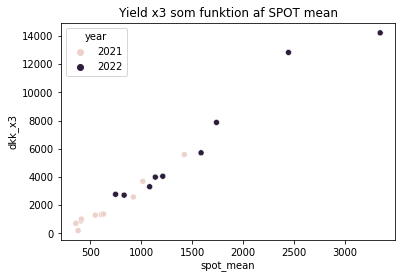

In [96]:
sns.scatterplot(data=df_samp, x='spot_mean', y='dkk_x3', hue='year')
plt.title('Yield x3 som funktion af SPOT mean')
plt.show()

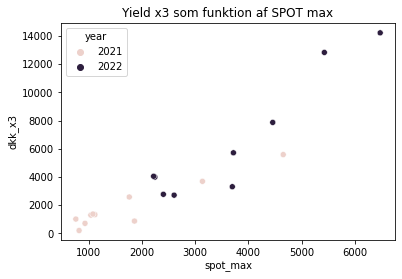

In [97]:
sns.scatterplot(data=df_samp, x='spot_max', y='dkk_x3', hue='year')
plt.title('Yield x3 som funktion af SPOT max')
plt.show()

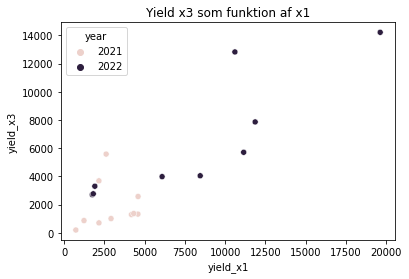

In [53]:
sns.scatterplot(data=df_samp, x='yield_x1', y='yield_x3', hue='year')
plt.title('Yield x3 som funktion af x1')
plt.show()

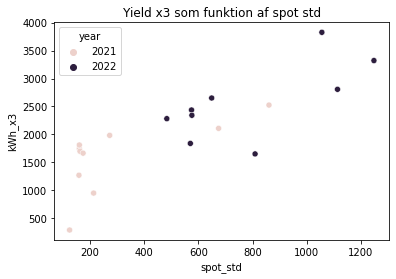

In [54]:
sns.scatterplot(data=df_samp, x='spot_std', y='kWh_x3', hue='year')
plt.title('Yield x3 som funktion af spot std')
plt.show()

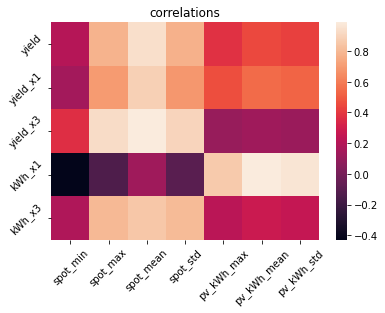

In [55]:
rows = ['yield', 'yield_x1', 'yield_x3', 'kWh_x1', 'kWh_x3']
cols = ['spot_min', 'spot_max', 'spot_mean', 'spot_std', 'pv_kWh_max', 'pv_kWh_mean', 'pv_kWh_std',]
sns.heatmap(df_samp.corr().loc[rows, cols])
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('correlations')
plt.show()